## Step 1 – Load the Cleaned Dataset

In [17]:
import sqlite3, pandas as pd

conn = sqlite3.connect("./../sql/retail_customer_experience.db")
df = pd.read_sql_query("SELECT * FROM customer_360_cleaned;", conn)
conn.close()

df.head()


,customer_id,full_name,city,gender,age,preferred_channel,frequency,monetary,avg_transaction_value,last_purchase_date,...,total_reviews,avg_rating,last_review_date,has_support_history,has_review,has_transaction,recency_days,engagement_score,satisfaction_index,clv_estimate
0,4c30e132-0704-4459-a509-9eddde934977,Mark Johnson,Houston,Male,40.0,Unknown,3,3565.72,1188.573333,2024-12-17 00:00:00,...,0,0.0,None,1,0,1,70.0,0.7,3.0,2991.925977
1,68bec407-275f-4b5b-9a82-13d02f54626a,Robert Smith,Austin,Male,33.0,in-store,9,8925.78,991.753333,2024-09-16 00:00:00,...,0,0.0,None,0,0,1,162.0,0.4,0.0,6181.991841
2,4466459f-76c8-433c-814e-6d59cb4131fc,Jamie Chavez,Detroit,Female,42.0,online,4,3820.41,955.102500,2025-02-14 00:00:00,...,0,0.0,None,0,0,1,11.0,0.4,0.0,3708.642686
3,04c36a25-02f3-462c-92b0-6bf291c57706,Thomas Bradley,Fort Worth,Male,53.0,both,6,1883.76,376.752000,2024-12-28 00:00:00,...,0,0.0,None,1,0,1,59.0,0.7,3.0,1621.633019
4,e916df3d-c3f5-40b0-8ae2-5d043be88300,Jane Ferrell,Atlanta,Female,32.0,online,15,8161.57,582.969286,2024-10-18 00:00:00,...,0,0.0,None,0,0,1,130.0,0.4,0.0,6018.127374


In [18]:
import numpy as np
df['churn_flag'] = np.where(df['recency_days'] > 180, 1, 0) # 1 = churned

## Step 2 – Define Targets & Features

| Model                  | Target variable          | Example features                                                                   |
| ---------------------- | ------------------------ | ---------------------------------------------------------------------------------- |
| **Churn Model**        | `churn_flag` *(derived)* | recency_days, frequency, monetary, avg_support_score, avg_rating, engagement_score |
| **Satisfaction Model** | `avg_support_score`      | total_tickets, avg_resolution_time, avg_rating, recency_days, monetary             |
| **Segmentation**       | none (unsupervised)      | recency_days, frequency, monetary, satisfaction_index, engagement_score            |


## Step 3 – Data Preparation

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# feature selection for churn model
X = df[['recency_days', 'frequency', 'monetary', 'avg_support_score', 'avg_rating', 'engagement_score']]
y = df['churn_flag']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 4 – Train a Churn Model

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       701
           1       0.99      0.99      0.99       299

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

ROC-AUC: 0.9999427478184533


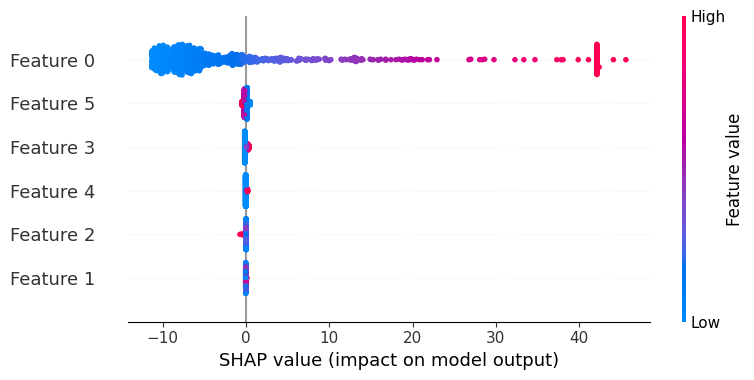

In [21]:
import shap
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test, show=False)


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

features = ['total_tickets','avg_resolution_time','avg_rating','recency_days','monetary']
target = 'avg_support_score'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MAE: 0.4255880441441084
R²: 0.7828260300680703


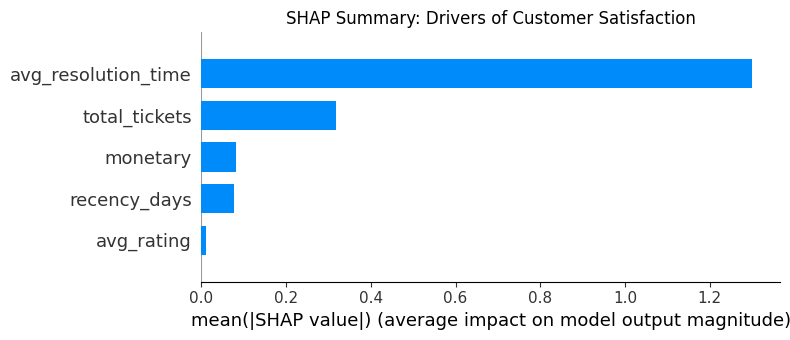

In [23]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer
explainer = shap.Explainer(rf, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# --- 1️⃣ Global Feature Importance ---
plt.title("SHAP Summary: Drivers of Customer Satisfaction")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)


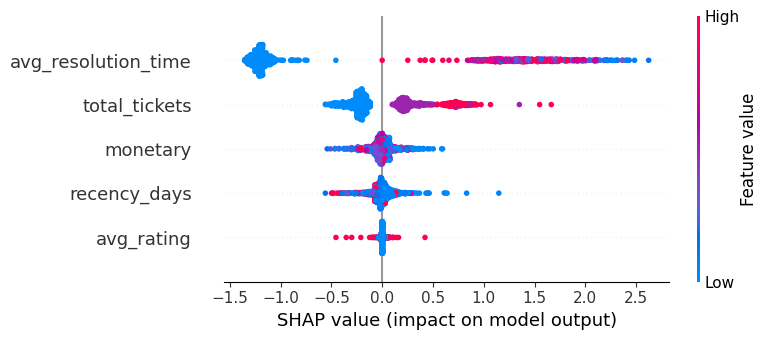

In [24]:
# --- 2️⃣ Detailed Feature Impact Scatter ---
shap.summary_plot(shap_values, X_test, show=True)


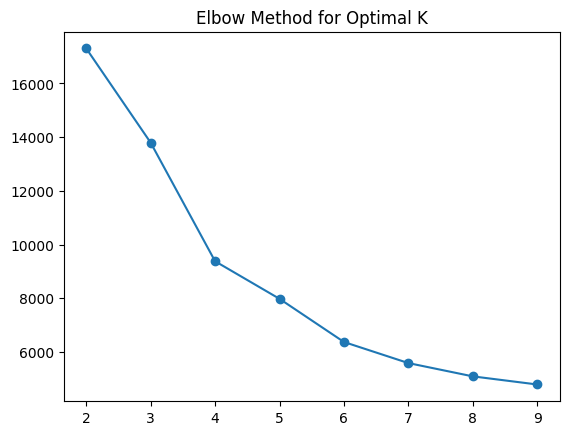

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

features = ['recency_days','frequency','monetary','satisfaction_index','engagement_score']
X = df[features].copy()
X_scaled = StandardScaler().fit_transform(X)

# choose k
inertia = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,10), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.show()


In [26]:
kmeans = KMeans(n_clusters=6, random_state=42)
df['segment'] = kmeans.fit_predict(X_scaled)


## Step 2 — 2D Visualization with PCA

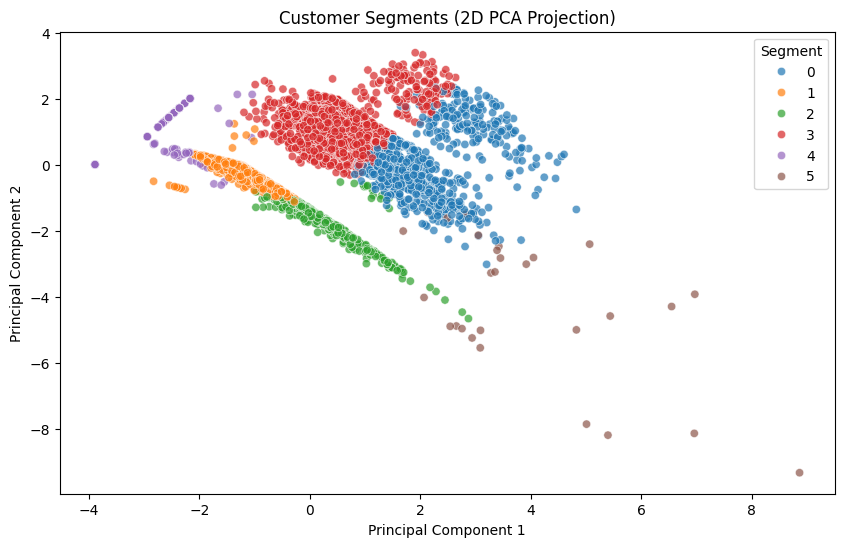

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='pca1',
    y='pca2',
    hue='segment',
    palette='tab10',
    alpha=0.7
)
plt.title("Customer Segments (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Segment')
plt.show()


## tep 3 — Cluster Summary Heatmap

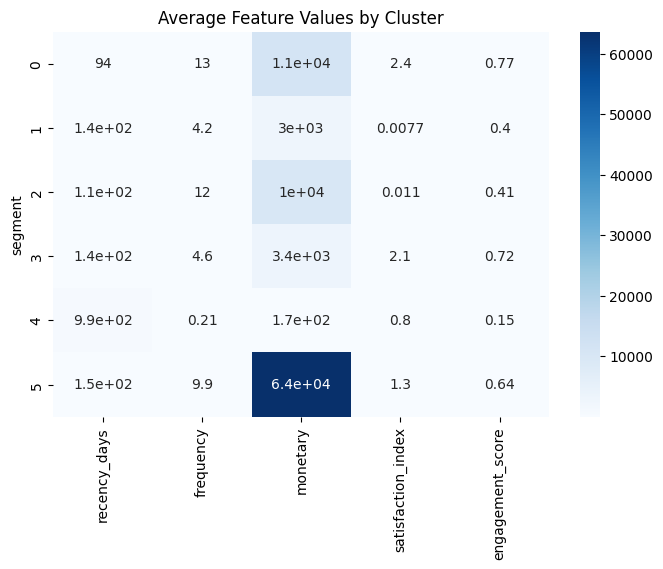

In [28]:
cluster_summary = df.groupby('segment')[features].mean()

plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary, annot=True, cmap='Blues')
plt.title("Average Feature Values by Cluster")
plt.show()


In [29]:
import plotly.express as px
import pandas as pd

cluster_summary = df.groupby('segment')[features].mean().reset_index()
cluster_summary = cluster_summary.melt(id_vars='segment', var_name='Feature', value_name='Value')

fig = px.line_polar(cluster_summary, r='Value', theta='Feature', color='segment', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(title="Cluster Profiles (Radar Chart)")
fig.show()


In [30]:
df.groupby('segment')[['monetary','frequency','recency_days','satisfaction_index']].mean()


,monetary,frequency,recency_days,satisfaction_index
segment,,,,
0,11234.285323,12.631313,94.015152,2.367761
1,3030.805066,4.172164,135.793536,0.007652
2,10133.811097,11.931083,107.659634,0.010689
3,3407.147422,4.626381,144.028590,2.101889
4,166.310145,0.207729,988.925121,0.800845
5,63642.801537,9.892857,154.571429,1.325000


In [31]:
df.head()

,customer_id,full_name,city,gender,age,preferred_channel,frequency,monetary,avg_transaction_value,last_purchase_date,...,has_review,has_transaction,recency_days,engagement_score,satisfaction_index,clv_estimate,churn_flag,segment,pca1,pca2
0,4c30e132-0704-4459-a509-9eddde934977,Mark Johnson,Houston,Male,40.0,Unknown,3,3565.72,1188.573333,2024-12-17 00:00:00,...,0,1,70.0,0.7,3.0,2991.925977,0,3,0.783039,1.590813
1,68bec407-275f-4b5b-9a82-13d02f54626a,Robert Smith,Austin,Male,33.0,in-store,9,8925.78,991.753333,2024-09-16 00:00:00,...,0,1,162.0,0.4,0.0,6181.991841,0,2,-0.218759,-1.287288
2,4466459f-76c8-433c-814e-6d59cb4131fc,Jamie Chavez,Detroit,Female,42.0,online,4,3820.41,955.102500,2025-02-14 00:00:00,...,0,1,11.0,0.4,0.0,3708.642686,0,1,-0.737077,-0.558371
3,04c36a25-02f3-462c-92b0-6bf291c57706,Thomas Bradley,Fort Worth,Male,53.0,both,6,1883.76,376.752000,2024-12-28 00:00:00,...,0,1,59.0,0.7,3.0,1621.633019,0,3,0.987056,1.420974
4,e916df3d-c3f5-40b0-8ae2-5d043be88300,Jane Ferrell,Atlanta,Female,32.0,online,15,8161.57,582.969286,2024-10-18 00:00:00,...,0,1,130.0,0.4,0.0,6018.127374,0,2,0.351305,-1.817700


In [32]:
import joblib
joblib.dump(model, "./churn_model.pkl")
joblib.dump(rf, "./satisfaction_model.pkl")
df.to_sql("customer_360_predicted", sqlite3.connect("./../sql/retail_customer_experience.db"), if_exists="replace", index=False)


5000

In [35]:
import sqlite3, pandas as pd

conn = sqlite3.connect("./../sql/retail_customer_experience.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('customers',), ('transactions',), ('support_tickets',), ('campaigns',), ('customer_reviews',), ('interactions',), ('customer_360_cleaned',), ('customer_360_predicted',), ('customer_sentiment',), ('customer_360_enriched',)]


In [41]:
df_customer_360_cleaned = pd.read_sql_query("SELECT * FROM customer_360_cleaned;", conn)
df_customer_360_predicted = pd.read_sql_query("SELECT * FROM customer_360_predicted;", conn)
df_customer_sentiment = pd.read_sql_query("SELECT * FROM customer_sentiment;", conn)
df_customer_360_enriched = pd.read_sql_query("SELECT * FROM customer_360_enriched;", conn)

In [43]:
df_customer_sentiment.columns

Index(['customer_id', 'sentiment_score'], dtype='object')